# CO2 emissions prediction for cars sold in France

- Import libraries

In [1]:
# libraries used for data exploration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimpy import skim

# librairies used for machine learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeRegressor, export_text
import xgboost as xgb

# utils
import gc

import warnings
warnings.filterwarnings('ignore')

In [2]:
def regression_metrics(y_true, y_pred):
    r2 = round(r2_score(y_true, y_pred), 4)
    mae = round(mean_absolute_error(y_true, y_pred), 4)
    mse = round(mean_squared_error(y_true, y_pred), 4)
    rmse = round(np.sqrt(mse), 4)
    
    print(f"R2= {r2}\nMean Absolute Error (MAE)= {mae}\nMean Squared Error (MSE)= {mse}\nRoot Mean Square Error (RMSE)= {rmse}")

- Import data

In [3]:
df = pd.read_csv("../data/dataset.csv")
df.head()

,make,model,energy,car_classification,cylinder_capacity,market_category,tax_horsepower,max_horsepower,electrical_nominal_power,weight,...,bonus_malus,low_speed_fuel_consumption,average_speed_fuel_consumption,high_speed_fuel_consumption,very_high_speed_fuel_consumption,combined_speed_fuel_consumption,elect_conso,electrical_autonomy,city_electrical_autonomy,co2_emission
0,renault,kangoo,gasoline,leisure_activity_vehicle,1332,low,7,96.0,NaN,1519,...,malus,8.7405,6.7880,6.188,7.9175,7.2635,NaN,NaN,NaN,167.272
1,mazda,mx-30,electric,crossover_suv,0,low,6,NaN,80.9,1645,...,bonus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ds,7_crossback,phev_gas,crossover_suv,1598,average_high,10,133.0,30.0,1760,...,neutral,NaN,NaN,NaN,NaN,1.5340,162.5,58.5,67.5,NaN
3,renault,austral,hev_gas,crossover_suv,1199,average_high,7,96.0,0.0,1421,...,neutral,6.5805,5.0200,4.834,5.9555,5.5025,NaN,NaN,NaN,126.073
4,b.m.w.,218,gasoline,compact_multi_purpose_vehicle,1499,average_low,7,100.0,NaN,1470,...,malus,8.9420,6.6295,5.637,6.4505,6.5680,NaN,NaN,NaN,155.826


The dataset used here is a simplified version of the original, available on the [ADEME](https://www.ademe.fr/en/frontpage/) (French Agency for Ecological Transition) website. To understand how the simplification was achieved, notebook *001.preparation_translation* presents all the steps involved. This notebook also includes a translation to help non-French speakers understand the different variables.

## 1) Data Preparation

Let's take a look to our data.

In [4]:
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 7679   │ │ float64     │ 12    │                                                          │
│ │ Number of columns │ 23     │ │ string      │ 7     │                                                          │
│ └───────────────────┴────────┘ │ int32       │ 4     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name             ┃ NA    ┃ NA %   ┃ mean   ┃ sd     ┃ p0    ┃ p25   ┃ p50   ┃ p75   ┃ p100 ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━━┩  │
│ │ cylinder_capacity       │     0 │      0 │   1700 │    680 │     0 │  1400 │  1600 │  2000 │ 6700 │  ▂▇▁   │  │
│ │ tax_horsepower          │     0 │      0 │     10 │    7.7 │     1 │     6 │     8 │    10 │   91 │   ▇▁   │  │
│ │ max_horsepower          │   269 │    3.5 │    130 │     66 │    48 │    92 │   110 │   140 │  610 │  ▇▂▁   │  │
│ │ electrical_nominal_powe │  4925 │  64.14 │     25 │     32 │     0 │     0 │    10 │    48 │  200 │  ▇▂▁   │  │
│ │ r                       │       │        │        │        │       │       │       │       │      │        │  │
│ │ weight                  │     0 │      0 │   1600 │    340 │   840 │  1300 │  1500 │  1800 │ 2700 │ ▂▇▆▃▁  │  │
│ │ weight_horsepower_ratio │     0 │      0 │  0.079 │  0.035 │     0 │  0.06 │  0.07 │  0.09 │ 0.37 │  ▃▇▁   │  │
│ │ no_gears                │     0 │      0 │    6.7 │    1.9 │     0 │     6 │     7 │     8 │    9 │ ▁   ▇▆ │  │
│ │ low_speed_fuel_consumpt │   989 │  12.88 │      8 │    2.2 │   3.2 │   6.7 │   7.8 │   8.9 │   30 │   ▇▇   │  │
│ │ ion                     │       │        │        │        │       │       │       │       │      │        │  │
│ │ average_speed_fuel_cons │   989 │  12.88 │    6.1 │    1.3 │   3.3 │   5.2 │   5.9 │   6.7 │   18 │  ▆▇▁   │  │
│ │ umption                 │       │        │        │        │       │       │       │       │      │        │  │
│ │ high_speed_fuel_consump │   989 │  12.88 │    5.4 │      1 │   3.7 │   4.7 │   5.3 │   5.8 │   14 │  ▇▆▁   │  │
│ │ tion                    │       │        │        │        │       │       │       │       │      │        │  │
│ │ very_high_speed_fuel_co │   989 │  12.88 │    6.5 │    1.1 │   4.2 │   5.7 │   6.3 │     7 │   14 │  ▅▇▂   │  │
│ │ nsumption               │       │        │        │        │       │       │       │       │      │        │  │
│ │ combined_speed_fuel_con │   395 │   5.14 │    5.9 │    1.7 │  0.56 │   5.2 │     6 │   6.8 │   17 │  ▁▆▇   │  │
│ │ sumption                │       │        │        │        │       │       │       │       │      │        │  │
│ │ elect_conso             │  6861 │  89.35 │    200 │     42 │   130 │   160 │   190 │   240 │  290 │ ▇▇▅▃▆▂ │  │
│ │ electrical_autonomy     │  6861 │  89.35 │    140 │    140 │    40 │    50 │    64 │   120 │  680 │  ▇ ▁▁  │  │
│ │ city_electrical_autonom │  6861 │  89.35 │    170 │    180 │    41 │    55 │    74 │   170 │  740 │ ▇  ▁▁  │  │
│ │ y                       │       │        │        │ 

The dataset contains 7679 rows and 23 columns. Of these 23 columns, 7 represent categorical variables and the rest contain quantitative variables.
As far as missing values are concerned, only numerical variables have missing values. Two strategies were chosen to fill them:
- For variables relating to electricity consumption, missing values will be filled in with 0. 
- For other variables, missing values will be filled by the median.

In [5]:
# create list with categorical variables
categorical = list(df.dtypes[df.dtypes == 'object'].index)

In [6]:
# create list with numerical variables
# target (co2_emission) is removed
numerical = [i for i in list(df.columns) if i not in categorical]
numerical.pop(-1)

'co2_emission'

- Dealing with missing values

In [7]:
# fill variables about electric consumption
df["electrical_autonomy"] = df["electrical_autonomy"].fillna(0)
df["electrical_nominal_power"] = df["electrical_nominal_power"].fillna(0)
df["elect_conso"] = df["elect_conso"].fillna(0)
df["city_electrical_autonomy"] = df["city_electrical_autonomy"].fillna(0)

In [8]:
# fill other numerical variables
for c in numerical:
    df[c] = df[c].fillna(df[c].median())

In [9]:
# fill target variable
df["co2_emission"] = df["co2_emission"].fillna(df["co2_emission"].median())

In [10]:
# verify if missing values are processed
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 7679   │ │ float64     │ 12    │                                                          │
│ │ Number of columns │ 23     │ │ string      │ 7     │                                                          │
│ └───────────────────┴────────┘ │ int32       │ 4     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name              ┃ NA  ┃ NA %  ┃ mean    ┃ sd     ┃ p0    ┃ p25   ┃ p50   ┃ p75   ┃ p100  ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ cylinder_capacity        │   0 │     0 │    1700 │    680 │     0 │  1400 │  1600 │  2000 │  6700 │  ▂▇▁   │  │
│ │ tax_horsepower           │   0 │     0 │      10 │    7.7 │     1 │     6 │     8 │    10 │    91 │   ▇▁   │  │
│ │ max_horsepower           │   0 │     0 │     130 │     65 │    48 │    96 │   110 │   140 │   610 │  ▇▂▁   │  │
│ │ electrical_nominal_power │   0 │     0 │       9 │     23 │     0 │     0 │     0 │     0 │   200 │   ▇▁   │  │
│ │ weight                   │   0 │     0 │    1600 │    340 │   840 │  1300 │  1500 │  1800 │  2700 │ ▂▇▆▃▁  │  │
│ │ weight_horsepower_ratio  │   0 │     0 │   0.079 │  0.035 │     0 │  0.06 │  0.07 │  0.09 │  0.37 │  ▃▇▁   │  │
│ │ no_gears                 │   0 │     0 │     6.7 │    1.9 │     0 │     6 │     7 │     8 │     9 │ ▁   ▇▆ │  │
│ │ low_speed_fuel_consumpti │   0 │     0 │       8 │    2.1 │   3.2 │   6.8 │   7.8 │   8.7 │    30 │   ▆▇   │  │
│ │ on                       │     │       │         │        │       │       │       │       │       │        │  │
│ │ average_speed_fuel_consu │   0 │     0 │     6.1 │    1.2 │   3.3 │   5.3 │   5.9 │   6.5 │    18 │   ▅▇   │  │
│ │ mption                   │     │       │         │        │       │       │       │       │       │        │  │
│ │ high_speed_fuel_consumpt │   0 │     0 │     5.4 │   0.96 │   3.7 │   4.8 │   5.3 │   5.7 │    14 │   ▇▅   │  │
│ │ ion                      │     │       │         │        │       │       │       │       │       │        │  │
│ │ very_high_speed_fuel_con │   0 │     0 │     6.4 │    1.1 │   4.2 │   5.8 │   6.3 │   6.9 │    14 │  ▃▇▁   │  │
│ │ sumption                 │     │       │         │        │       │       │       │       │       │        │  │
│ │ combined_speed_fuel_cons │   0 │     0 │     5.9 │    1.7 │  0.56 │   5.3 │     6 │   6.7 │    17 │  ▁▅▇   │  │
│ │ umption                  │     │       │         │        │       │       │       │       │       │        │  │
│ │ elect_conso              │   0 │     0 │      21 │     63 │     0 │     0 │     0 │     0 │   290 │   ▇    │  │
│ │ electrical_autonomy      │   0 │     0 │      15 │     62 │     0 │     0 │     0 │     0 │   680 │   ▇    │  │
│ │ city_electrical_autonomy │   0 │     0 │      18 │     79 │     0 │     0 │     0 │     0 │   740 │   ▇    │  │
│ │ co2_emission             │   0 │     0 │     150 │     29 │    93 │   140 │   150 │   160 │   410 │  ▆▇▁   │  │
│ └──────────────────────────┴─────┴───────┴─────────┴──

Missing values are processed. Exploratory analysis can be performed.

## 2) Exploratory Data Analysis

EDA consists of two parts.

In the first part, each variable is analyzed individually to get an idea of its behavior on its own, without interaction. In the second part, a bivariate analysis is performed. The aim of this analysis is to understand the interaction between the target (CO2 emissions) and the different variables.

### a) Univariate Analysis

#### 1. Target

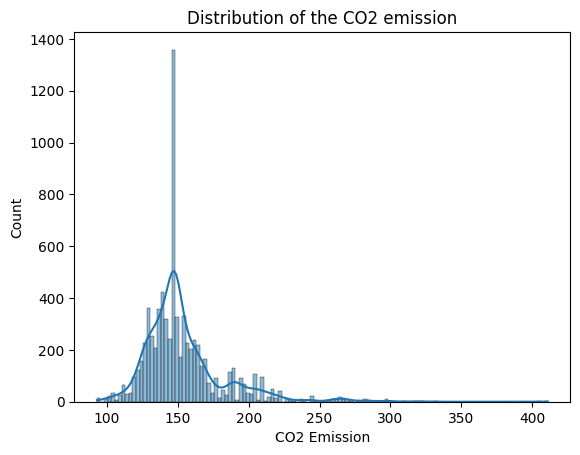

In [11]:
sns.histplot(
    data = df,
    x = "co2_emission",
    kde=True
)
plt.xlabel("CO2 Emission")
plt.title("Distribution of the CO2 emission")
plt.show()

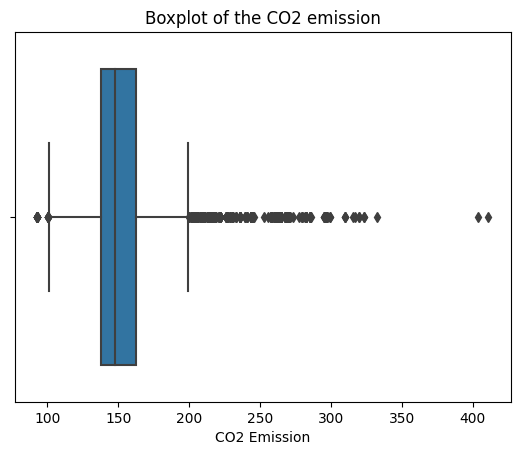

In [12]:
sns.boxplot(
    x="co2_emission",
    data=df
)
plt.xlabel("CO2 Emission")
plt.title('Boxplot of the CO2 emission')
plt.show()

In [13]:
df["co2_emission"].describe()

count    7679.000000
mean      153.747830
std        28.787887
min        92.947000
25%       137.461000
50%       147.635000
75%       162.221000
max       411.010000
Name: co2_emission, dtype: float64

Since a linear regression will be carried out at a later date, the target variable will be transformed. This is because linear models are sensitive to asymmetry in the distribution of a variable. To avoid any problems during model training, the target variable is transformed by a logarithmic function.
Here, Numpy's log1p function is used for this transformation. The log1p function adds 1 before performing a logarithmic transformation. This avoids log(0), which creates an undefined value.

```np.log1p(x)``` = $1 + log(x)$

In [14]:
# log transformation
df["co2_emission"] = np.log1p(df["co2_emission"])

#### 2. Features

##### Categorical features

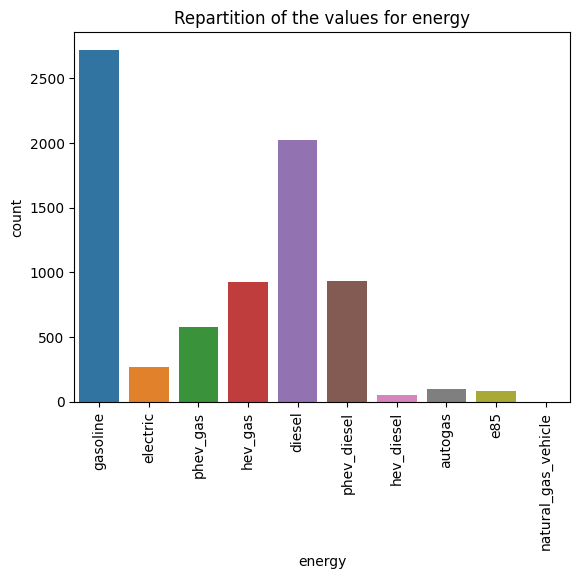

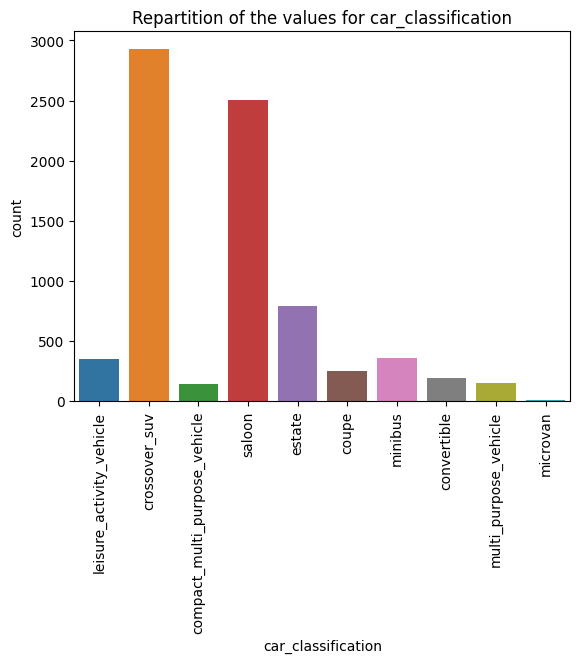

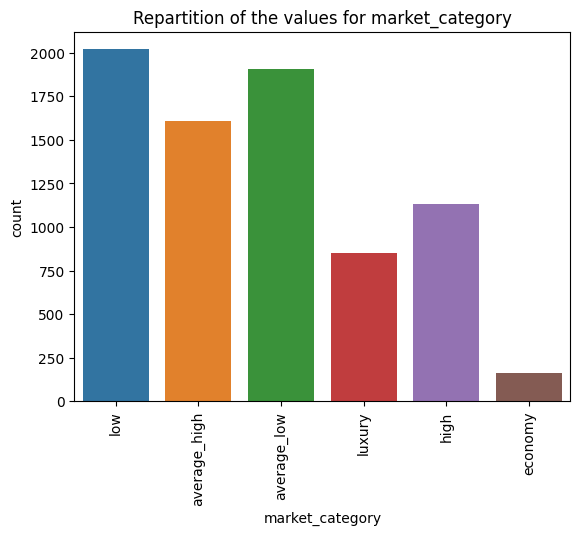

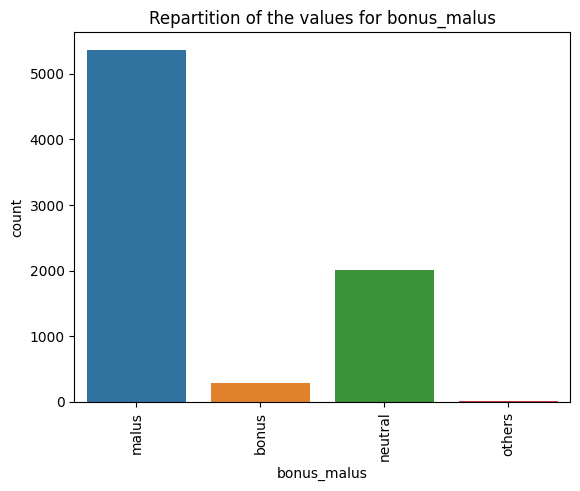

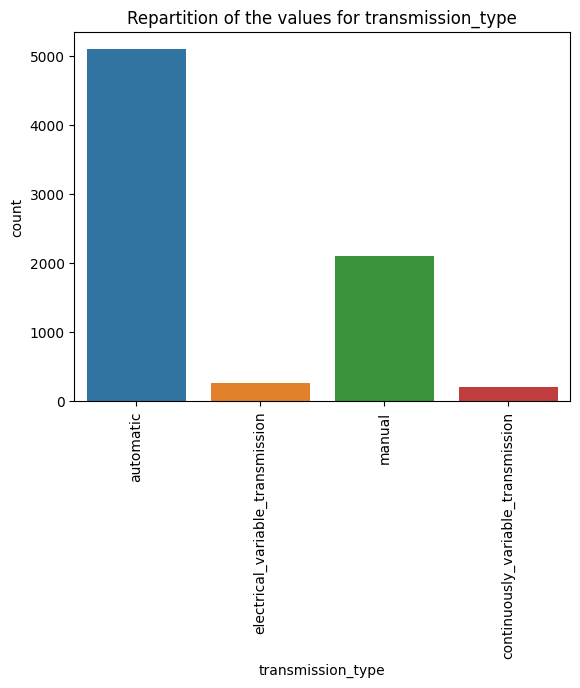

In [15]:
for col in ['energy', 'car_classification', 'market_category', 'bonus_malus', "transmission_type"]:
    sns.countplot(
        x=col,
        data=df
        )
    plt.title(f"Repartition of the values for {col}")
    plt.xticks(rotation=90)
    plt.show()

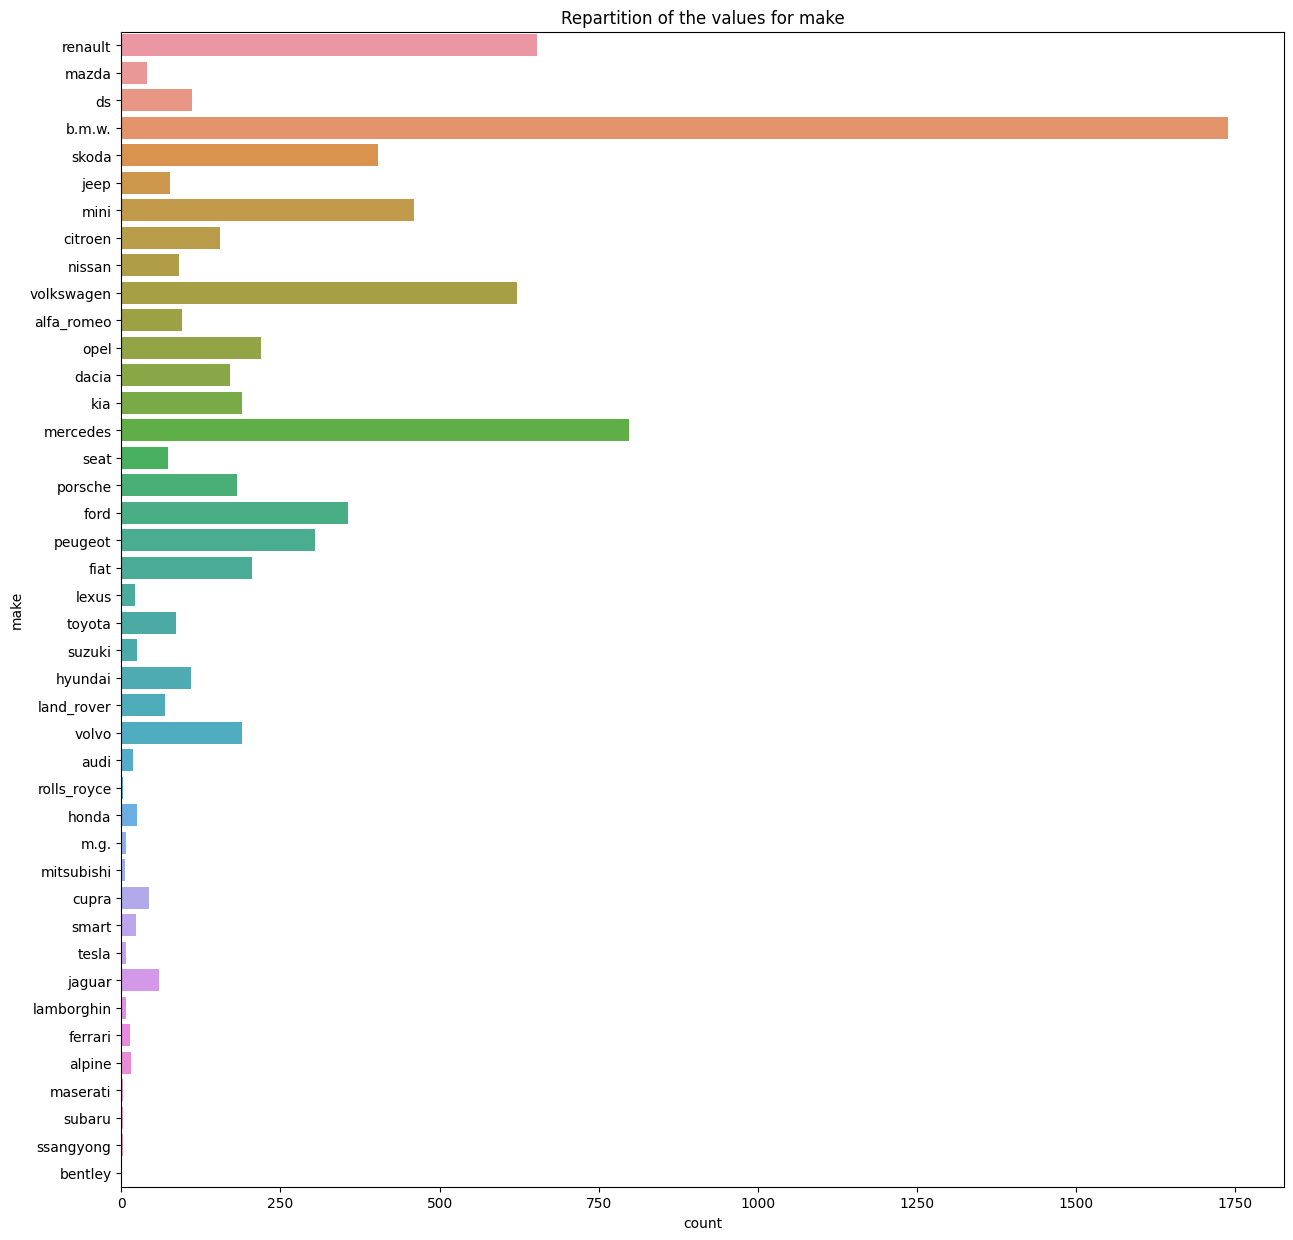

In [16]:
plt.figure(figsize=(15,15))

sns.countplot(
    y="make",
    data=df
)
plt.title(f"Repartition of the values for make")
plt.show()

##### Numerical features

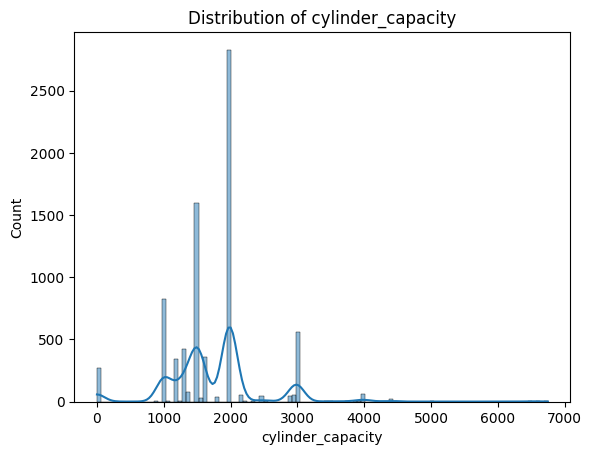

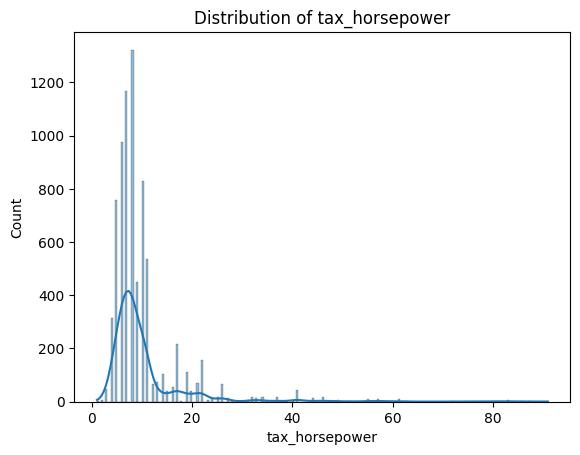

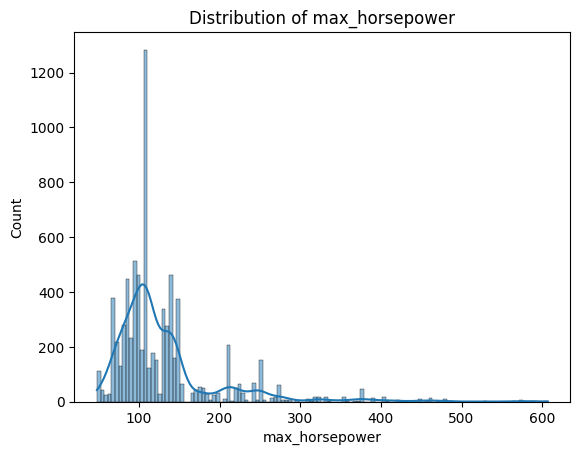

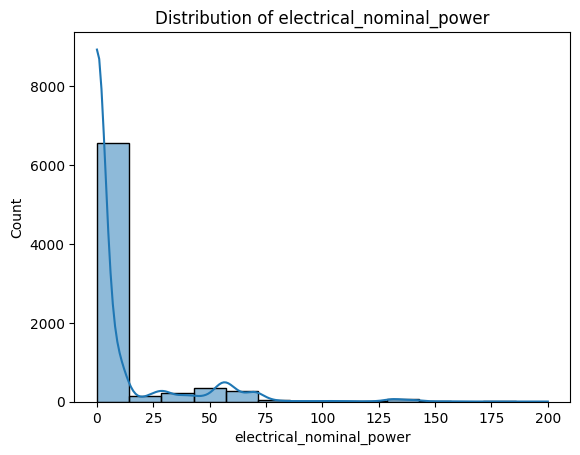

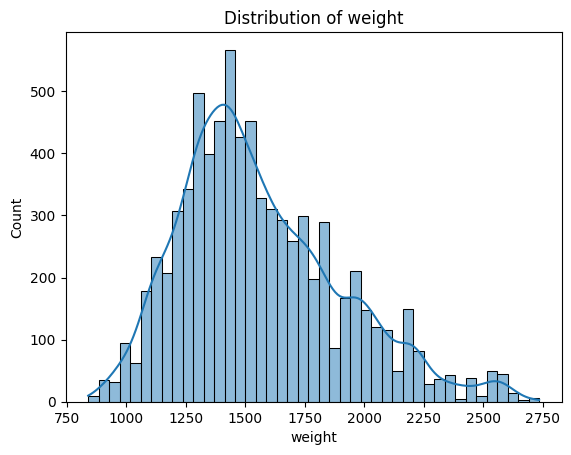

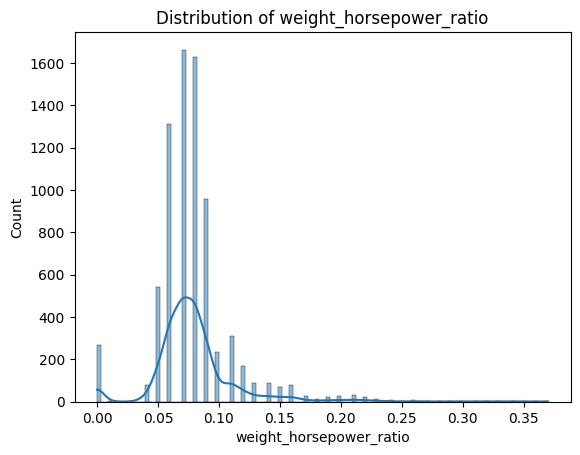

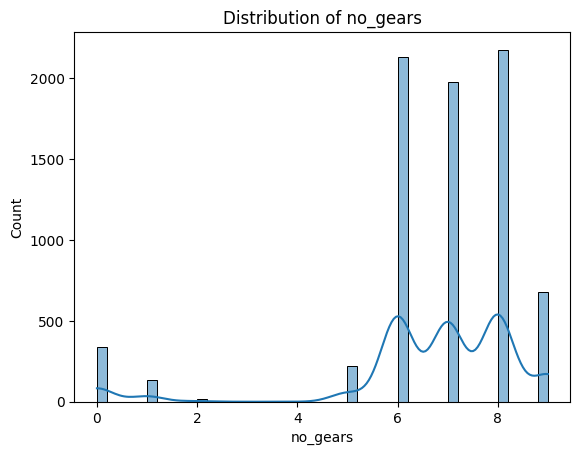

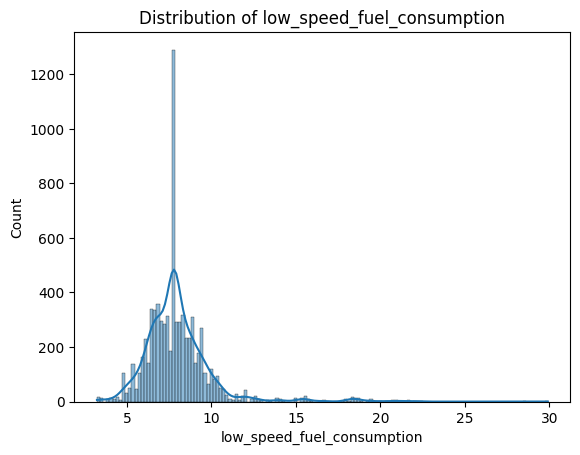

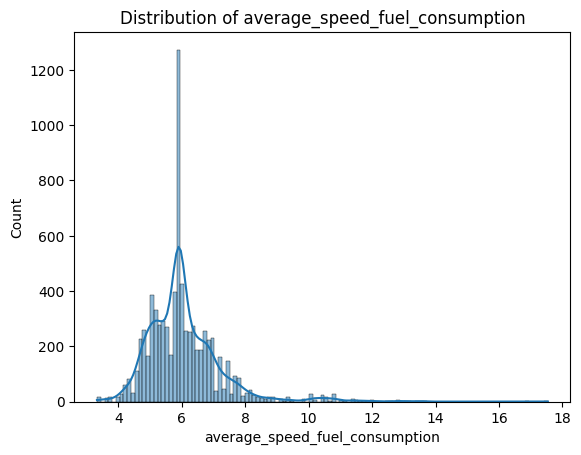

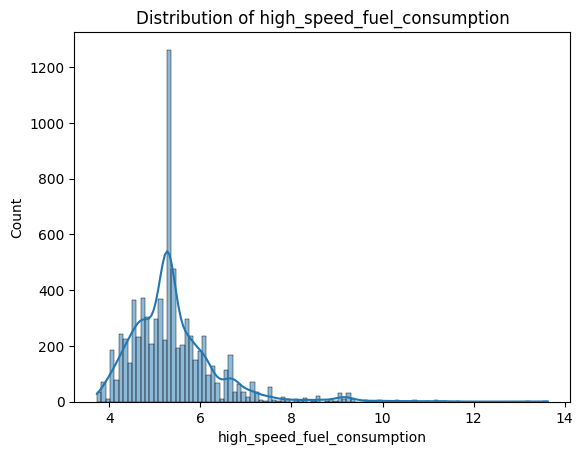

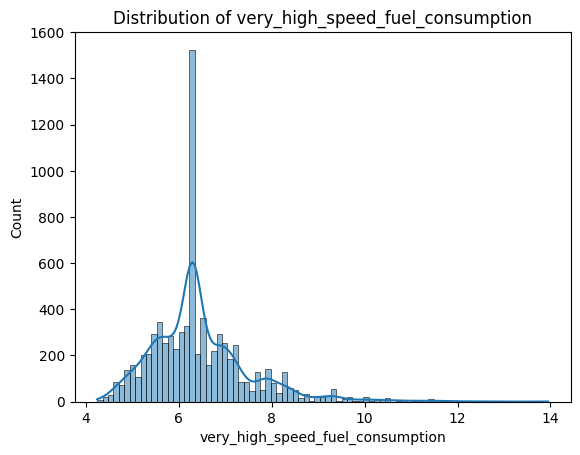

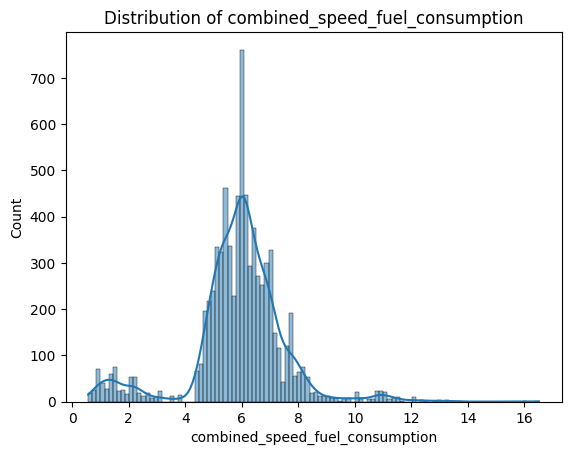

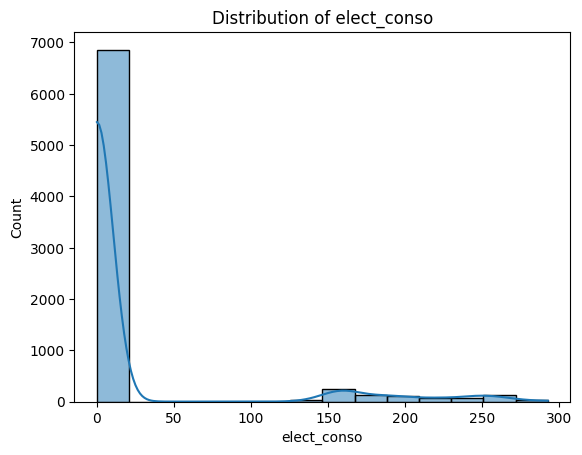

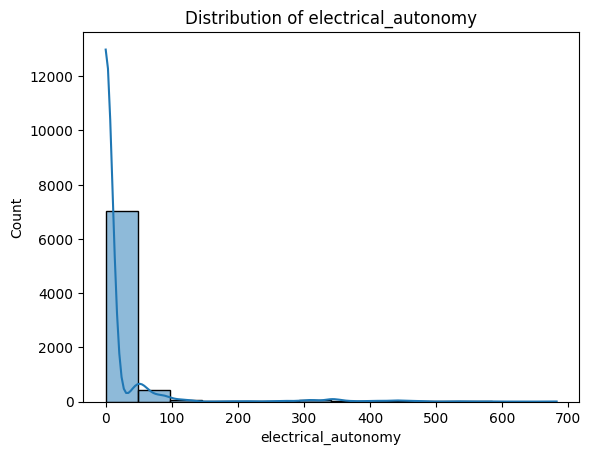

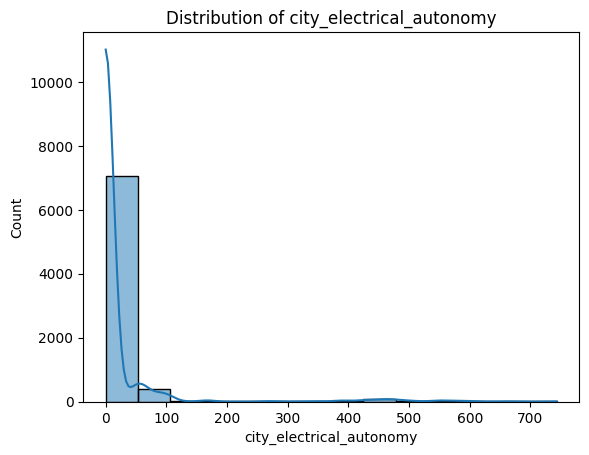

In [17]:
for col in numerical:
    sns.histplot(
        x=col,
        data=df,
        kde=True
        )
    plt.title(f"Distribution of {col}")
    plt.show()

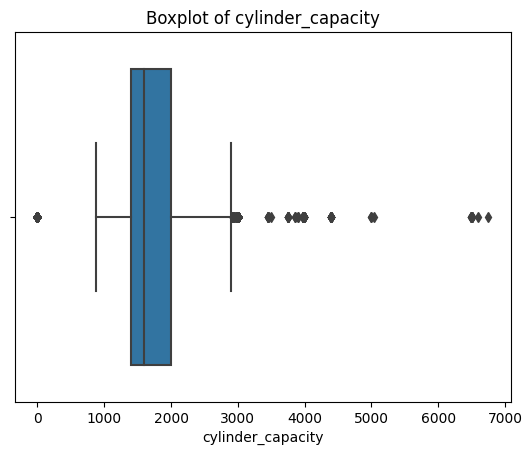

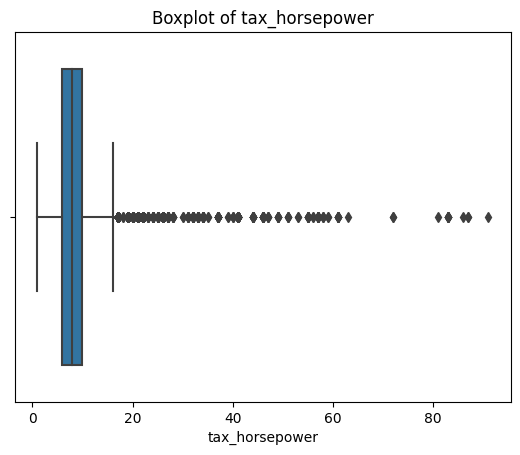

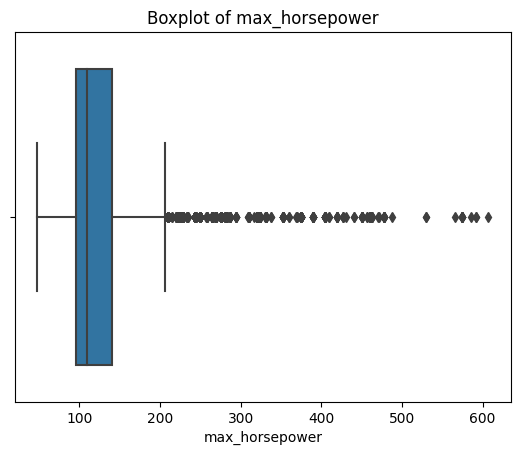

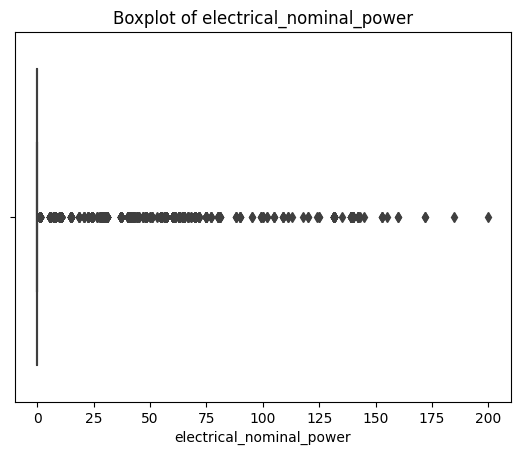

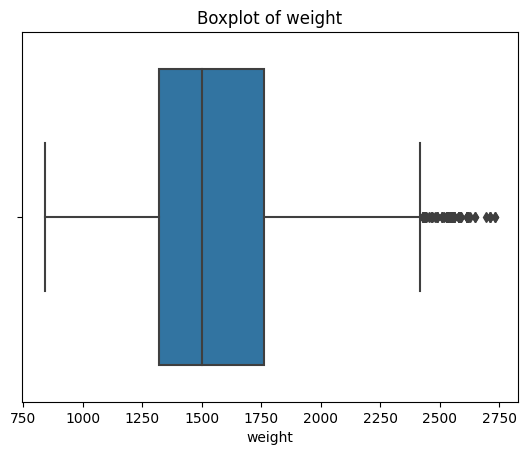

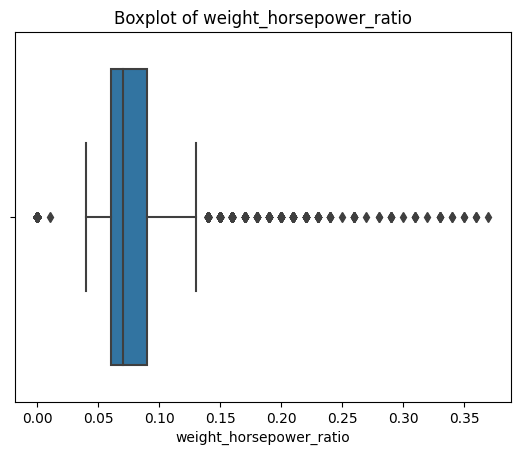

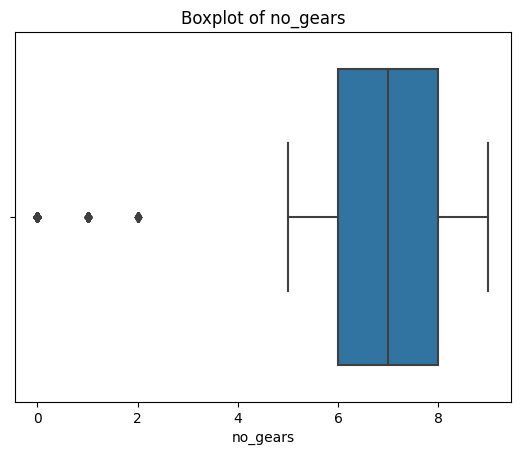

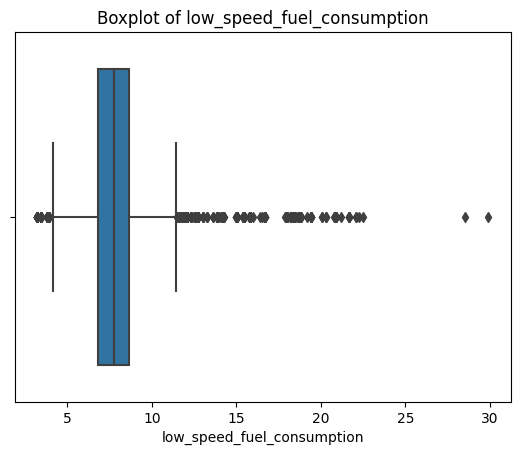

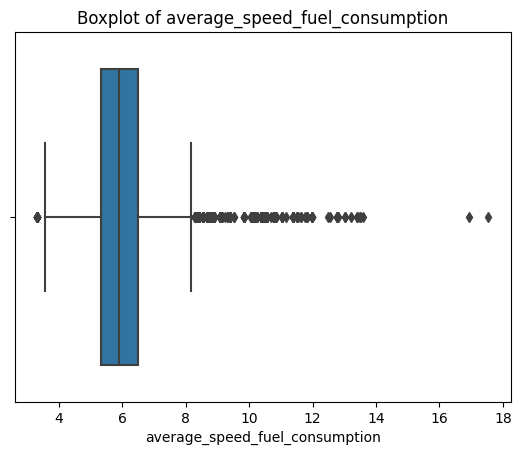

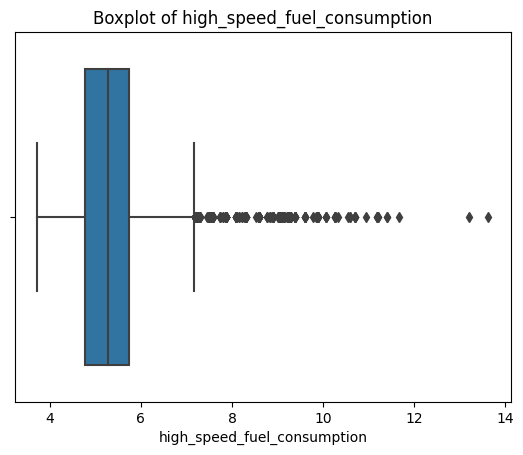

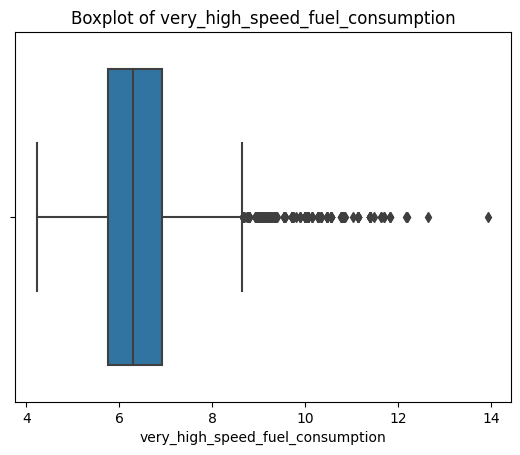

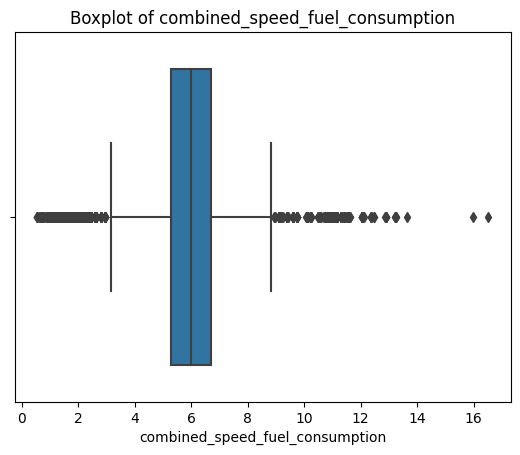

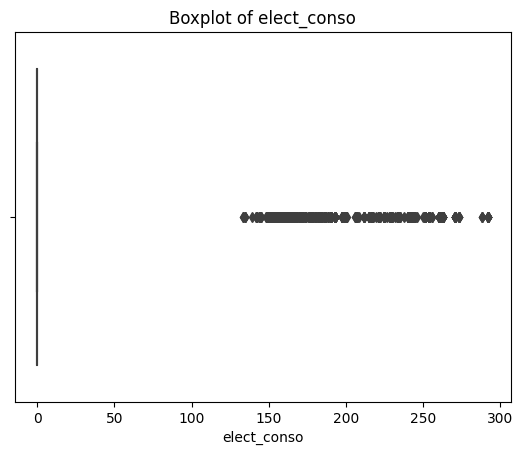

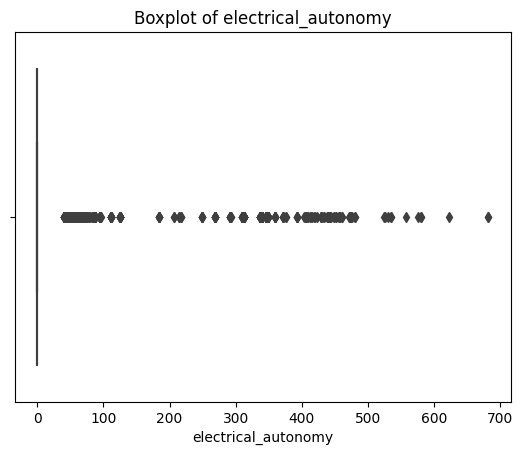

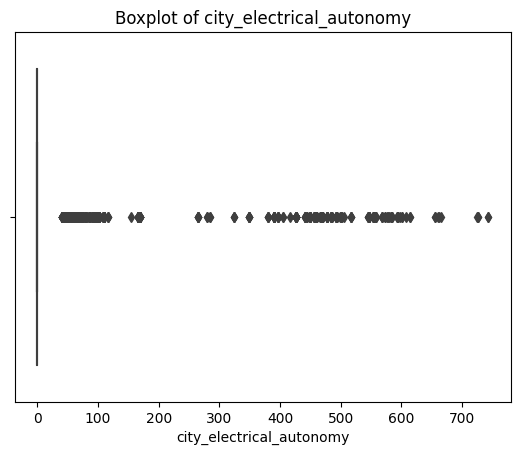

In [18]:
for col in numerical:
    sns.boxplot(
        x = col,
        data = df
        )
    plt.title(f"Boxplot of {col}")
    plt.show()

In [19]:
df.describe()

,cylinder_capacity,tax_horsepower,max_horsepower,electrical_nominal_power,weight,weight_horsepower_ratio,no_gears,low_speed_fuel_consumption,average_speed_fuel_consumption,high_speed_fuel_consumption,very_high_speed_fuel_consumption,combined_speed_fuel_consumption,elect_conso,electrical_autonomy,city_electrical_autonomy,co2_emission
count,7679.000000,7679.000000,7679.000000,7679.000000,7679.000000,7679.000000,7679.000000,7679.000000,7679.000000,7679.000000,7679.000000,7679.000000,7679.000000,7679.000000,7679.000000,7679.000000
mean,1733.046360,10.051048,129.310587,9.030096,1562.189478,0.079177,6.698659,7.986213,6.054569,5.389588,6.442503,5.901909,21.175792,14.608907,18.164273,5.026920
std,684.378835,7.740399,65.317899,22.632754,339.289158,0.034537,1.946159,2.091453,1.171831,0.960321,1.061567,1.674401,62.821355,61.514699,79.016732,0.167239
min,0.000000,1.000000,48.000000,0.000000,840.000000,0.000000,0.000000,3.219000,3.327000,3.726000,4.238500,0.562000,0.000000,0.000000,0.000000,4.542731
25%,1395.000000,6.000000,95.600000,0.000000,1320.000000,0.060000,6.000000,6.831000,5.329500,4.780000,5.760000,5.274500,0.000000,0.000000,0.000000,4.930589
50%,1598.000000,8.000000,110.000000,0.000000,1500.000000,0.070000,7.000000,7.765000,5.912500,5.267500,6.296000,5.987000,0.000000,0.000000,0.000000,5.001494
75%,1995.000000,10.000000,140.000000,0.000000,1763.000000,0.090000,8.000000,8.663500,6.513000,5.736500,6.917000,6.709000,0.000000,0.000000,0.000000,5.095105
max,6749.000000,91.000000,607.000000,200.000000,2735.000000,0.370000,9.000000,29.914500,17.541500,13.632000,13.947000,16.521500,292.500000,682.500000,743.150000,6.021048


### b) Multivariate analysis

#### 1. Relation between target and numerical variables

In [20]:
numerical.append("co2_emission")

Text(0.5, 1.0, 'Correlation matrix between the different numerical variables')

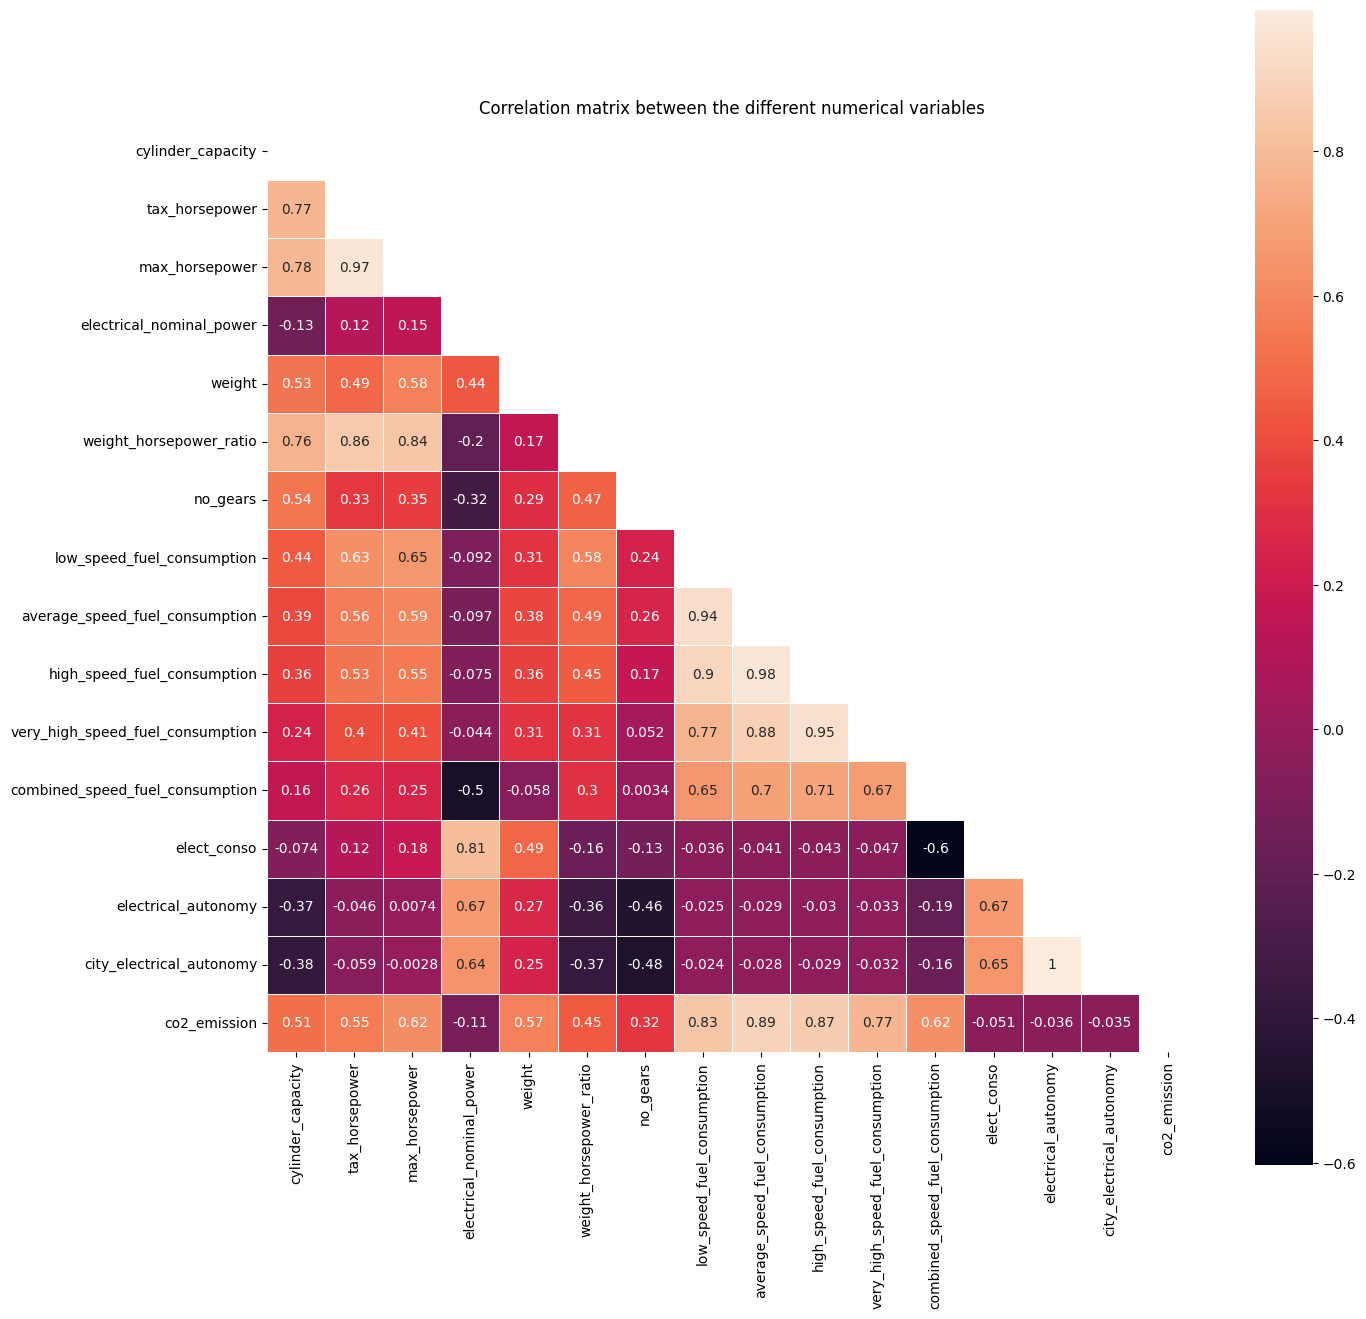

In [21]:
corr_matrix = df[numerical].corr()
mask = np.triu(corr_matrix)

plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, 
            mask=mask, 
            linewidths=.5, 
            annot=True, 
            cbar=True, 
            square=True)
plt.title("Correlation matrix between the different numerical variables")

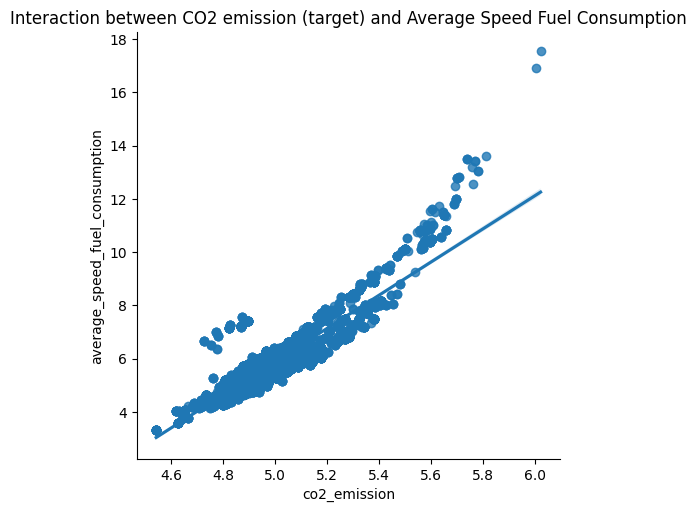

In [22]:
sns.lmplot(
    data=df,
    x="co2_emission",
    y="average_speed_fuel_consumption"
    )
plt.title("Interaction between CO2 emission (target) and Average Speed Fuel Consumption")
plt.show()

#### 2. Relation between target and categorical variables

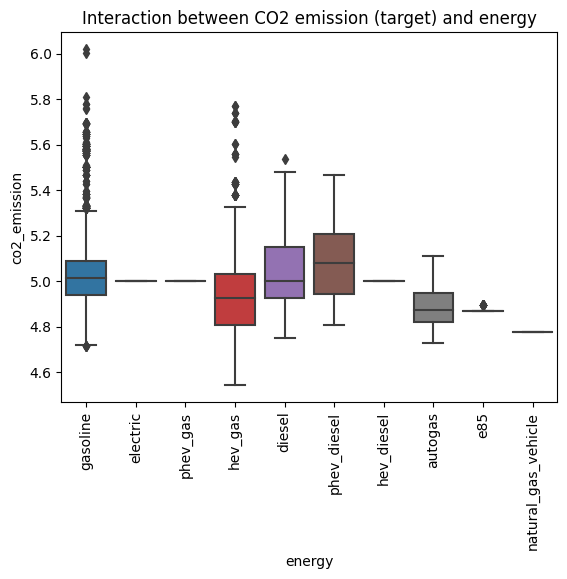

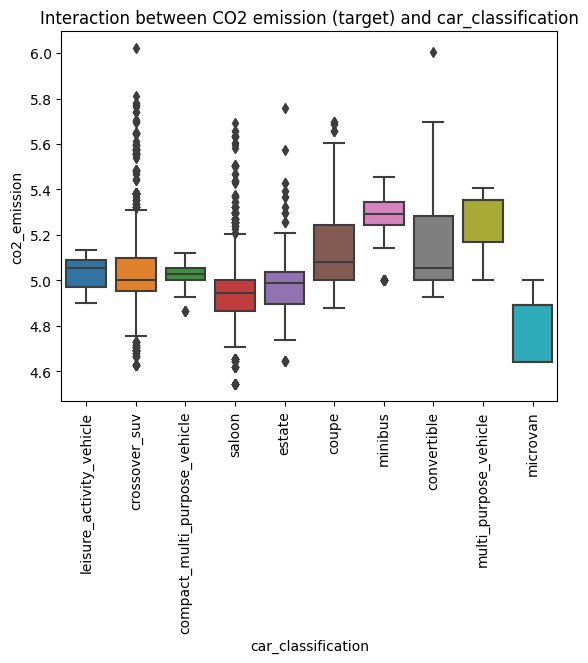

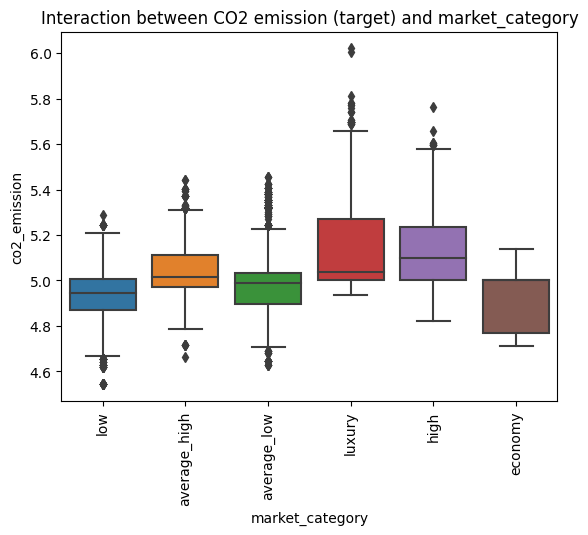

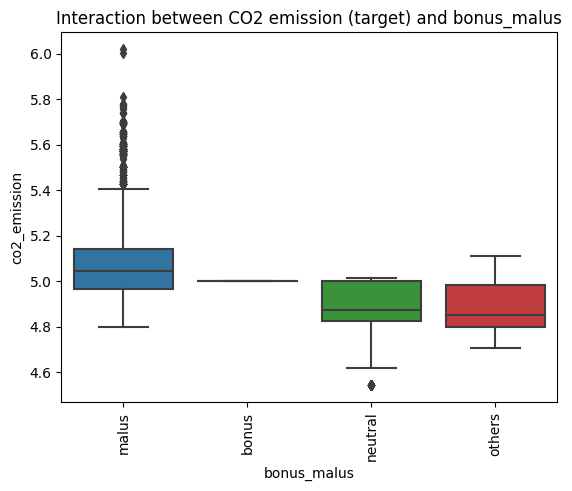

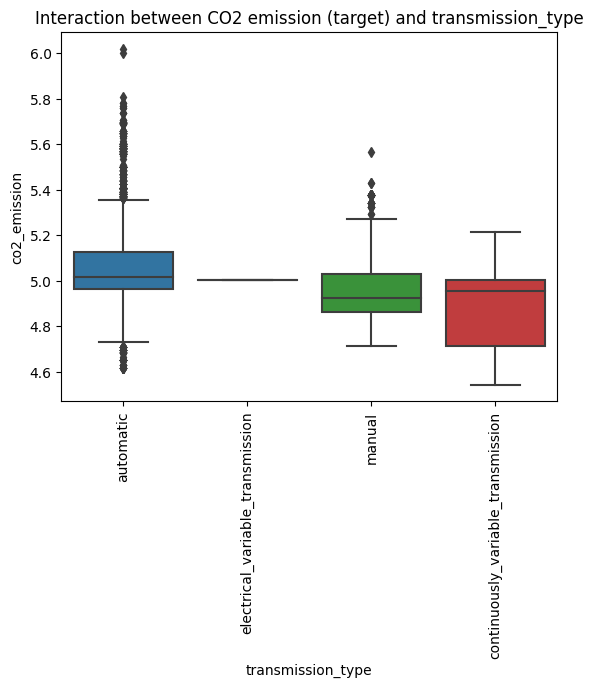

In [23]:
for col in ['energy', 'car_classification', 'market_category', 'bonus_malus', "transmission_type"]:
    sns.boxplot(
        data=df,
        x=col, 
        y="co2_emission"
        )
    plt.title(f"Interaction between CO2 emission (target) and {col}")
    plt.xticks(rotation=90)
    plt.show()

## 3) Modelisation

### a) Data Preparation

- Split data in different sets

In [24]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [25]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [26]:
y_train = df_train["co2_emission"].values
y_val = df_val["co2_emission"].values
y_test = df_test["co2_emission"].values

In [27]:
del df_train['co2_emission']
del df_val['co2_emission']
del df_test['co2_emission']

- Standard and Robust Scaler

In [28]:
numerical.pop(-1)

'co2_emission'

In [29]:
scaler = RobustScaler()
df_train[numerical] = scaler.fit_transform(df_train[numerical])
df_val[numerical] = scaler.transform(df_val[numerical])
df_test[numerical] = scaler.transform(df_test[numerical])

- DictVectorizer

In [30]:
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')
test_dicts = df_test.to_dict(orient='records')

In [31]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)
X_test = dv.transform(test_dicts)

### b) Baseline model

In [32]:
dummy = DummyRegressor(strategy="median")
dummy.fit(X_train, y_train)

DummyRegressor(strategy='median')

In [33]:
y_pred = dummy.predict(X_val)

In [34]:
regression_metrics(y_val, y_pred)

R2= -0.0253
Mean Absolute Error (MAE)= 0.1143
Mean Squared Error (MSE)= 0.027
Root Mean Square Error (RMSE)= 0.1643


In [35]:
del y_pred
gc.collect()

81591

### c) Linear Model

In [36]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [37]:
y_pred = lr.predict(X_val)

In [38]:
regression_metrics(y_val, y_pred)

R2= -412812745199.371
Mean Absolute Error (MAE)= 6257.5929
Mean Squared Error (MSE)= 10890885105.7711
Root Mean Square Error (RMSE)= 104359.4035


In [39]:
del y_pred
gc.collect()

0

### d) Decision Tree

In [40]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [41]:
y_pred = dt.predict(X_val)

In [42]:
regression_metrics(y_val, y_pred)

R2= 0.9956
Mean Absolute Error (MAE)= 0.0013
Mean Squared Error (MSE)= 0.0001
Root Mean Square Error (RMSE)= 0.01


In [43]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- average_speed_fuel_consumption <= 1.17
|   |--- average_speed_fuel_consumption <= -0.28
|   |   |--- bonus_malus=malus <= 0.50
|   |   |   |--- low_speed_fuel_consumption <= -1.26
|   |   |   |   |--- average_speed_fuel_consumption <= -1.53
|   |   |   |   |   |--- combined_speed_fuel_consumption <= -1.09
|   |   |   |   |   |   |--- make=toyota <= 0.50
|   |   |   |   |   |   |   |--- value: [4.54]
|   |   |   |   |   |   |--- make=toyota >  0.50
|   |   |   |   |   |   |   |--- value: [4.54]
|   |   |   |   |   |--- combined_speed_fuel_consumption >  -1.09
|   |   |   |   |   |   |--- weight_horsepower_ratio <= -0.50
|   |   |   |   |   |   |   |--- combined_speed_fuel_consumption <= -0.97
|   |   |   |   |   |   |   |   |--- value: [4.62]
|   |   |   |   |   |   |   |--- combined_speed_fuel_consumption >  -0.97
|   |   |   |   |   |   |   |   |--- very_high_speed_fuel_consumption <= -0.07
|   |   |   |   |   |   |   |   |   |--- average_speed_fuel_consumption <= -1.68
|   |   |

In [44]:
del y_pred
gc.collect()

205

### e) Random Forest

In [45]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [46]:
y_pred = rf.predict(X_val)

In [47]:
regression_metrics(y_val, y_pred)

R2= 0.9988
Mean Absolute Error (MAE)= 0.0011
Mean Squared Error (MSE)= 0.0
Root Mean Square Error (RMSE)= 0.0


In [48]:
del y_pred
gc.collect()

44

### f) XGBoost

## 4) Conclusion